<a href="https://colab.research.google.com/github/kwsk01/machine_learning/blob/main/Bayes/%E7%B5%84%E3%81%BF%E5%90%88%E3%82%8F%E3%81%9B%E3%82%92%E8%80%83%E6%85%AE%E3%81%97%E3%81%9F%E7%B5%B1%E8%A8%88%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# import

In [67]:
import pymc3 as pm
import numpy as np
from matplotlib import pyplot as plt

In [68]:
n = [434,382,394,88]
clicks = [8,17,10,4]
#n/clicks = [0.018, 0.04, 0.025, 0.04]

# クリックの割合のみ考慮したモデル

$$
  \theta \sim Beta(1,1)\\
a \sim Binomial(\theta,N)
$$

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  after removing the cwd from sys.path.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 10 seconds.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """


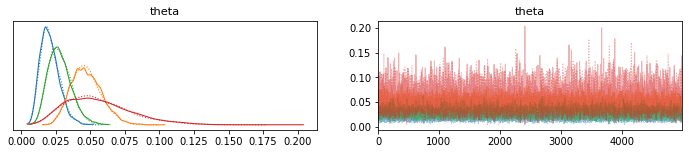

In [69]:
with pm.Model() as model:
  theta = pm.Beta('theta',alpha=1,beta=1,shape=len(n))
  obs = pm.Binomial('obs',p=theta, n=n, observed=clicks)
  trace = pm.sample(5000,chains=2)
  pm.traceplot(trace,compact=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  


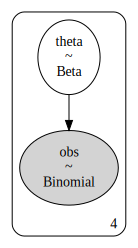

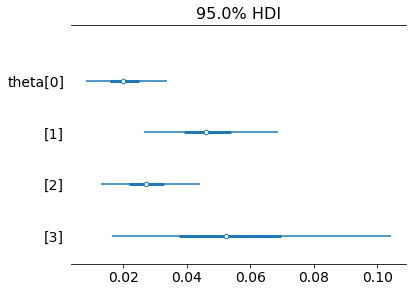

In [70]:
with model:
  pm.forestplot(trace,combined=True,hdi_prob=0.95)
pm.model_to_graphviz(model)

#効果に着目したモデリング

$$
  \alpha \sim Normal(0,10)\\
  \beta_1 \sim Normal(0,10)\\
  \beta_2 \sim Normal(0,10)\\
  \theta = logistic(\alpha + \beta_1 x_1 + \beta_2 x_2 )\\
a \sim Binomial(\theta,N)
$$

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # Remove the CWD from sys.path while we load stuff.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 17 seconds.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  # This is added back by InteractiveShellApp.init_path()


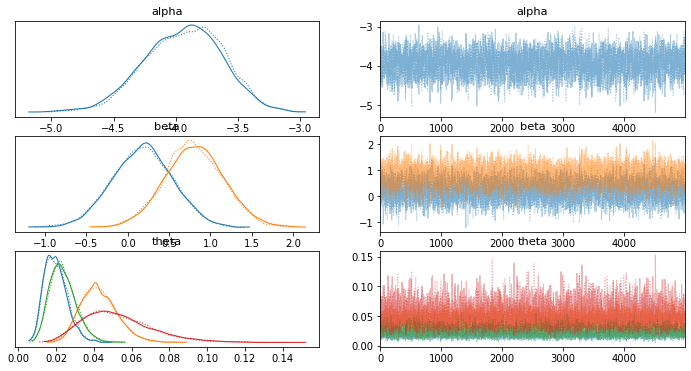

In [71]:
img = [0,0,1,1]
btn = [0,1,0,1]

with pm.Model() as model_comb:
  alpha = pm.Normal('alpha', mu = 0, sigma=10)
  beta = pm.Normal('beta', mu = 0, sigma=10, shape=2)
  comb = alpha + beta[0] * img + beta[1] *btn
  theta = pm.Deterministic('theta', 1/(1 + pm.math.exp(-comb)))
  obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
  trace_comb = pm.sample(5000,chains=2)
  pm.traceplot(trace_comb, compact=True)

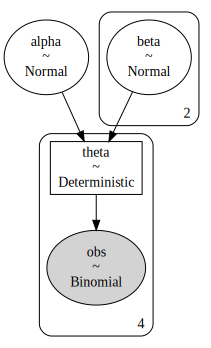

In [72]:
pm.model_to_graphviz(model_comb)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  after removing the cwd from sys.path.


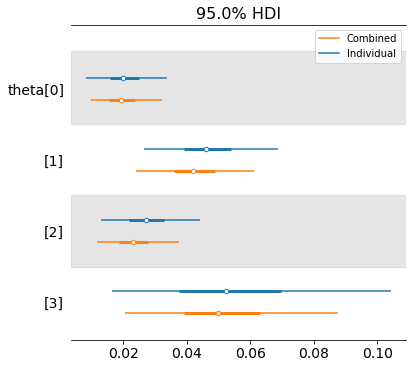

In [73]:
with pm.Model():
  pm.forestplot([trace,trace_comb], var_names=['theta'],
                hdi_prob=0.95,combined=True,
                model_names=['Individual','Combined'])

# 交互作用を加えたモデル

$$
  \alpha \sim Normal(0,10)\\
  \beta_1 \sim Normal(0,10)\\
  \beta_2 \sim Normal(0,10)\\
  \gamma \sim Normal(0,10)\\
  \theta = logistic(\alpha + \beta_1 x_1 + \beta_2 x_2 + \gamma x_1 x_2)\\
a \sim Binomial(\theta,N)
$$

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # This is added back by InteractiveShellApp.init_path()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [gamma, beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 22 seconds.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  if sys.path[0] == '':


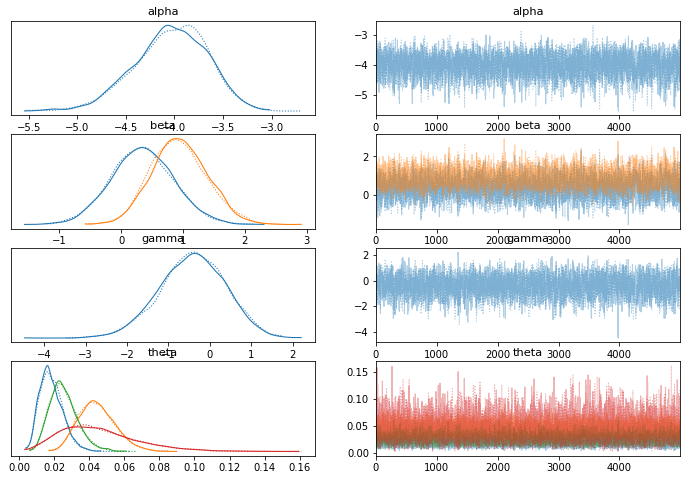

In [74]:
img = [0,0,1,1]
btn = [0,1,0,1]

with pm.Model() as model_int:#interaction
  alpha = pm.Normal('alpha', mu=0, sigma=10)
  beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
  gamma = pm.Normal('gamma', mu=0, sigma=10,)
  comb = alpha + beta[0] * img + beta[1] *btn + gamma * img *btn
  theta = pm.Deterministic('theta', 1/(1 + pm.math.exp(-comb)))
  obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
  trace_int = pm.sample(5000,chains=2)
  pm.traceplot(trace_int, compact=True)

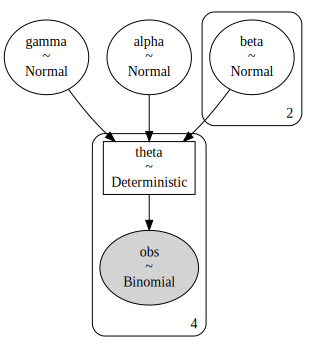

In [75]:
pm.model_to_graphviz(model_int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  """


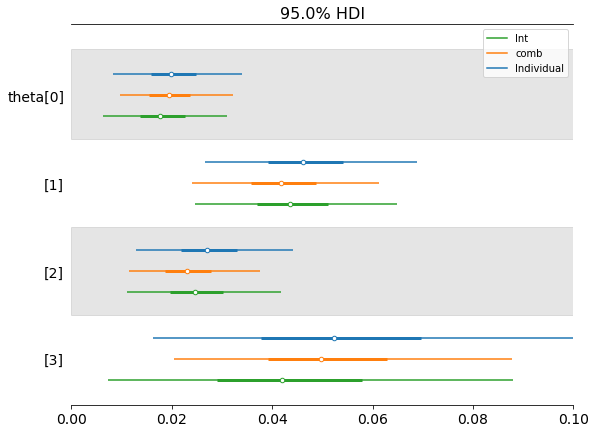

In [76]:
with pm.Model():
  pm.forestplot([trace,trace_comb,trace_int], var_names=['theta'],
                hdi_prob=0.95,combined=True,
                figsize=(9, 7),
                model_names=['Individual','comb','Int'])
  plt.xlim(0,0.1)
  plt.show()

In [77]:
with model:
  print(pm.summary(trace, hdi_prob=0.95))
  print('--------------------------')
  print(pm.summary(trace_comb, hdi_prob=0.95))
  print('--------------------------')
  print(pm.summary(trace_int, hdi_prob=0.95))

           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
theta[0]  0.021  0.007     0.008      0.034        0.0      0.0   13573.0   
theta[1]  0.047  0.011     0.027      0.069        0.0      0.0   12668.0   
theta[2]  0.028  0.008     0.013      0.044        0.0      0.0   13891.0   
theta[3]  0.056  0.024     0.016      0.104        0.0      0.0   13004.0   

          ess_tail  r_hat  
theta[0]    7332.0    1.0  
theta[1]    7272.0    1.0  
theta[2]    6918.0    1.0  
theta[3]    7580.0    1.0  
--------------------------


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:347: UserWarning: Could not compute log_likelihood, it will be omitted. Check your model object or set log_likelihood=False
  warnings.warn(warn_msg)


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha    -3.937  0.312    -4.547     -3.359      0.006    0.004    3125.0   
beta[0]   0.176  0.364    -0.518      0.889      0.006    0.004    3982.0   
beta[1]   0.802  0.355     0.124      1.519      0.006    0.004    3512.0   
theta[0]  0.020  0.006     0.010      0.032      0.000    0.000    3125.0   
theta[1]  0.043  0.010     0.024      0.061      0.000    0.000    8019.0   
theta[2]  0.024  0.007     0.012      0.038      0.000    0.000    7051.0   
theta[3]  0.052  0.018     0.021      0.088      0.000    0.000    4239.0   

          ess_tail  r_hat  
alpha       3696.0    1.0  
beta[0]     5037.0    1.0  
beta[1]     4509.0    1.0  
theta[0]    3696.0    1.0  
theta[1]    6818.0    1.0  
theta[2]    6691.0    1.0  
theta[3]    5514.0    1.0  
--------------------------
           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha    -4.037  0.377    -4.764     -3.327      0.007 

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:347: UserWarning: Could not compute log_likelihood, it will be omitted. Check your model object or set log_likelihood=False
  warnings.warn(warn_msg)


In [78]:
n = [434,382,394,412]
clicks = [8,17,10,8]
#n/clicks = [0.018, 0.04, 0.025, 0.019]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  after removing the cwd from sys.path.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 11 seconds.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """


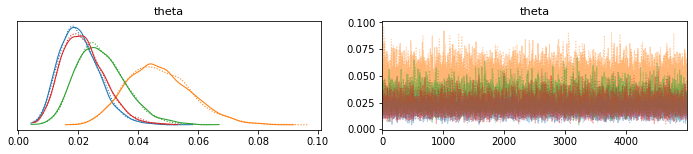

In [79]:
with pm.Model() as model:
  theta = pm.Beta('theta',alpha=1,beta=1,shape=len(n))
  obs = pm.Binomial('obs',p=theta, n=n, observed=clicks)
  trace = pm.sample(5000,chains=2)
  pm.traceplot(trace,compact=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  # Remove the CWD from sys.path while we load stuff.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 17 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  # This is added back by InteractiveShellApp.init_path()


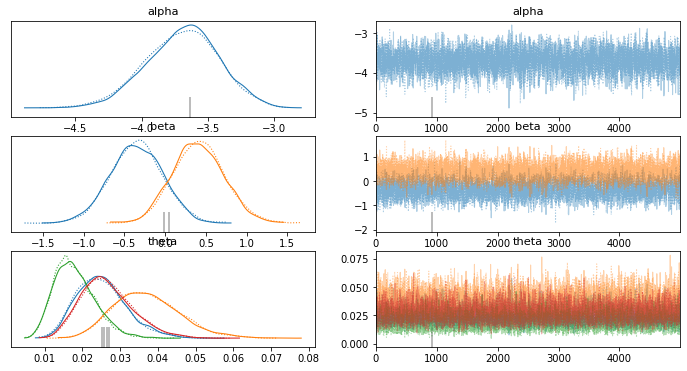

In [80]:
img = [0,0,1,1]
btn = [0,1,0,1]

with pm.Model() as model_comb:
  alpha = pm.Normal('alpha', mu = 0, sigma=10)
  beta = pm.Normal('beta', mu = 0, sigma=10, shape=2)
  comb = alpha + beta[0] * img + beta[1] *btn
  theta = pm.Deterministic('theta', 1/(1 + pm.math.exp(-comb)))
  obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
  trace_comb = pm.sample(5000,chains=2)
  pm.traceplot(trace_comb, compact=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [gamma, beta, alpha]


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 24 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  if __name__ == '__main__':


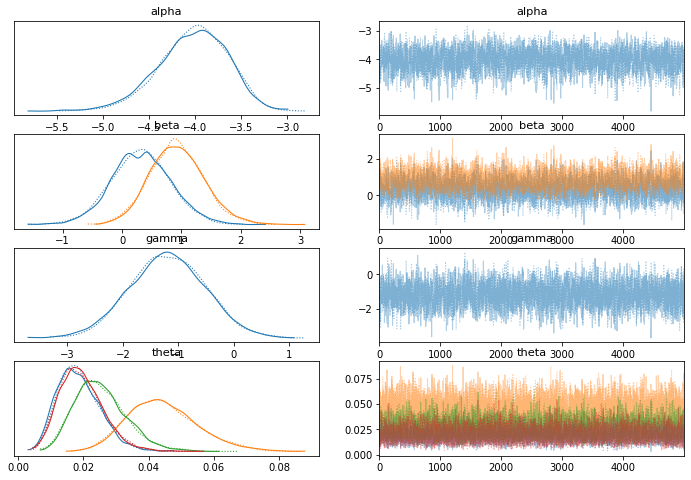

In [81]:
with pm.Model() as model_int:#interaction
  alpha = pm.Normal('alpha', mu=0, sigma=10)
  beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
  gamma = pm.Normal('gamma', mu=0, sigma=10,)
  comb = alpha + beta[0] * img + beta[1] *btn + gamma * img *btn
  theta = pm.Deterministic('theta', 1/(1 + pm.math.exp(-comb)))
  obs = pm.Binomial('obs', p=theta, n=n, observed=clicks)
  trace_int = pm.sample(5000,chains=2)
  pm.traceplot(trace_int, compact=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The function `forestplot` from PyMC3 is just an alias for `plot_forest` from ArviZ. Please switch to `pymc3.plot_forest` or `arviz.plot_forest`.
  """


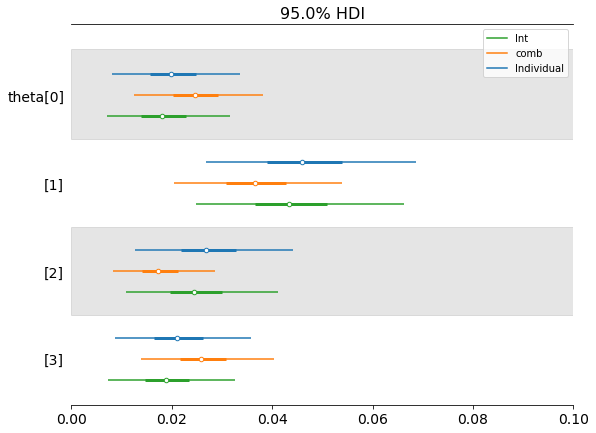

In [82]:
with pm.Model():
  pm.forestplot([trace,trace_comb,trace_int], var_names=['theta'],
                hdi_prob=0.95,combined=True,
                figsize=(9, 7),
                model_names=['Individual','comb','Int'])
  plt.xlim(0,0.1)
  plt.show()

In [83]:
with model:
  print(pm.summary(trace, hdi_prob=0.95))
  print('--------------------------')
  print(pm.summary(trace_comb, hdi_prob=0.95))
  print('--------------------------')
  print(pm.summary(trace_int, hdi_prob=0.95))

           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
theta[0]  0.021  0.007     0.008      0.034        0.0      0.0   12222.0   
theta[1]  0.047  0.011     0.027      0.069        0.0      0.0   14781.0   
theta[2]  0.028  0.008     0.013      0.044        0.0      0.0   14694.0   
theta[3]  0.022  0.007     0.009      0.036        0.0      0.0   12461.0   

          ess_tail  r_hat  
theta[0]    7161.0    1.0  
theta[1]    7711.0    1.0  
theta[2]    7520.0    1.0  
theta[3]    7238.0    1.0  
--------------------------


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:347: UserWarning: Could not compute log_likelihood, it will be omitted. Check your model object or set log_likelihood=False
  warnings.warn(warn_msg)


           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha    -3.694  0.276    -4.237     -3.163      0.004    0.003    3938.0   
beta[0]  -0.351  0.320    -0.977      0.274      0.005    0.003    4753.0   
beta[1]   0.410  0.317    -0.208      1.021      0.005    0.004    4644.0   
theta[0]  0.025  0.007     0.013      0.038      0.000    0.000    3938.0   
theta[1]  0.037  0.009     0.021      0.054      0.000    0.000    6421.0   
theta[2]  0.018  0.005     0.008      0.029      0.000    0.000    5554.0   
theta[3]  0.027  0.007     0.014      0.040      0.000    0.000    5921.0   

          ess_tail  r_hat  
alpha       4231.0    1.0  
beta[0]     4630.0    1.0  
beta[1]     4478.0    1.0  
theta[0]    4231.0    1.0  
theta[1]    6580.0    1.0  
theta[2]    6470.0    1.0  
theta[3]    6271.0    1.0  
--------------------------
           mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  ess_bulk  \
alpha    -4.023  0.373    -4.778     -3.343      0.009 

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3_3x.py:347: UserWarning: Could not compute log_likelihood, it will be omitted. Check your model object or set log_likelihood=False
  warnings.warn(warn_msg)
